![MLU Logo](../data/MLU_Logo.png)

# <a name="0">Machine Learning Accelerator - Natural Language Processing - Lecture 3</a>

## Word Vectors
Word vectors refers to a family of related techniques, first gaining popularity via ```Word2Vec``` which associates an $n$-dimensional (normally $n$ is in the range of $50$ to $500$.  For us it will be $300$) vector to every word in the target language.

We will first load a batch of word vectors known as [ConceptNet Numberbatch](https://github.com/commonsense/conceptnet-numberbatch), which have been found to have excellent performance while reducing issues of [learning human bias](https://gist.github.com/rspeer/ef750e7e407e04894cb3b78a82d66aed).  Learning how to construct these word vectors is a bit beyond the scope of what we can cover in this notebook, but [this two-part blog post provides an excellent introduction](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).

We will go over these:
1. <a href="#1">How to get the most from this notebook</a>
2. <a href="#2">Computing Distances</a>
3. <a href="#3">Linear Structure of Word Vectors (Subtraction)</a>
4. <a href="#4">Reverse Lookup</a>
5. <a href="#5">Application: Analogies</a>
6. <a href="#6">Visualization (PCA)</a>

## 1. <a name="1">How to get the most from this notebook</a>
(<a href="#0">Go to top</a>)

This builds out a solution in a step by step manner making it clear where data is being used and what tools are useful for exploration.  After every code block, I encourage you to explore your own problem from beginning to end using these tools.

In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved
# SPDX-License-Identifier: MIT-0

! wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz

--2020-07-08 04:10:54--  https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz
Resolving conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)... 52.216.86.99
Connecting to conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)|52.216.86.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269500348 (257M) [text/plain]
Saving to: ‘numberbatch-en-17.06.txt.gz’

numberbatch-en-17.0 100%[===================>] 257.01M  21.6MB/s    in 12s     

2020-07-08 04:11:07 (20.9 MB/s) - ‘numberbatch-en-17.06.txt.gz’ saved [269500348/269500348]



In [2]:
! gzip -d numberbatch-en-17.06.txt.gz

In [3]:
# Load our libraries
import pandas as pd
import numpy as np

# Load word vectors
words = pd.read_csv('numberbatch-en-17.06.txt',
                    sep=" ",
                    index_col=0,
                    header=None,
                    skiprows=[0]).transpose()

The code snippet above loads our wordvectors.  The Pandas table ```words``` allows us to perform lookups like ```words['house']``` to get the associated vectors.  Let's just print one out for reference.

In [4]:
print(words['house'])

1      0.0331
2      0.1253
3      0.0865
4      0.0641
5     -0.1315
6      0.0970
7      0.1629
8      0.0243
9     -0.0683
10     0.0350
11    -0.0947
12     0.0681
13    -0.0535
14     0.0319
15     0.0405
16     0.1862
17     0.0295
18     0.1933
19    -0.0285
20    -0.0522
21    -0.0774
22     0.0214
23     0.1540
24     0.1068
25     0.0057
26    -0.0042
27     0.0668
28     0.0256
29    -0.0074
30    -0.0184
        ...  
271   -0.0069
272    0.0027
273   -0.0044
274   -0.0749
275    0.0407
276   -0.0119
277   -0.0610
278   -0.0264
279    0.0140
280   -0.0210
281    0.0239
282   -0.0489
283    0.0130
284    0.0902
285   -0.0568
286    0.0647
287    0.0076
288   -0.0591
289    0.0574
290   -0.0442
291   -0.0673
292   -0.0040
293   -0.0435
294    0.0454
295    0.0311
296   -0.0046
297   -0.0053
298    0.0449
299   -0.0277
300   -0.0500
Name: house, Length: 300, dtype: float64


Such a vector is not particularly informative to us since it is not organized in a humanly readable way.

## 2. <a name="2">Computing Distances</a>
(<a href="#0">Go to top</a>)

As part of our "manipulation primitives", we often need to be able to compute distances between vectors associated to words.  So we start by writing a little snippet that lets us do so.  ```numpy``` makes this fairly easy to do.  Remember that small distances correspond to similar words, so lets check this by going through and writing a little code that takes three words and tells you if the first word is closer to the second than the third.

In [5]:
# define the distance between two words
def dist(w1,w2) :
    return np.linalg.norm(words[w1] - words[w2])
    
# Say if w1 is closer to w2 than w3
def distCompare(w1, w2, w3) :
    d2 = dist(w1,w2)
    d3 = dist(w1,w3)
    if d2 < d3 :
        print("{} is closer to {} than {}".format(w1,w2,w3))
    else :
        print("{} is closer to {} than {}".format(w1,w3,w2))

In [6]:
distCompare('orb','ball','hockey')
distCompare('picked','lifted','play')
distCompare('pink','red','blue')

orb is closer to ball than hockey
picked is closer to lifted than play
pink is closer to red than blue


We see that it mostly agrees with what we anticipated.  If you continued to ask more questions, you'd find some things that disagree with what you would expect (for instance, it believes that ```'maroon'``` is closer to ```'blue'``` than ```'red'```), but on the whole, you'll find it agrees with the intuition that similar words should be close to one another. 

## 3. <a name="3">Linear Structure of Word Vectors (Subtraction)</a>
(<a href="#0">Go to top</a>)

If word vectors only put similar words next to one another, they would have never garnered the interest that they have obtained from the community.  Indeed they actually contain subtle and nuanced understanding of the meanings of words.  It will take a while to explore what this means, but the mantra that we should now internalize is "relationships = directions" which is to say that words that share a similar relationship, will be separated from one another in the same direction.

As we saw, vector subtraction lets us examine this.  However, since vector subtraction is as simple as
```python
diff = v - w
```
there is not much to look at here.

## 4. <a name="4">Reverse Lookup</a>
(<a href="#0">Go to top</a>)

Reverse lookup will allow us to probe the finer structure of word vectors.  In particular, we will now create a reverse lookup routine that finds the $k$ closest words to a given vector.  As the straight-forward implementation will be too slow (looping over every element of ```words```) we will provide you with a ```numpy``` implementation which will be fast enough for our needs.

In [7]:
# drop things containing underscores (these are compound terms like "young_man" that our code will not use) and convert to matrix format for faster computation
labels  = words.columns.values.tolist()
labels = np.array([w for w in labels if isinstance(w,str) and w.isalpha()])
wordsMatrix = words[labels].as_matrix()

# snipped to find the closest word (or vector)
def find_closest_word(v, k = 1):
    if type(v) == type('str'):
        v = words[v]
    diff = wordsMatrix - v.values.reshape(-1,1)
    delta = np.linalg.norm(diff, axis=0)
    return labels[np.argsort(delta)[:k]]
    
# test with the 50 closest words to blue
print(find_closest_word('blue', 50))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


['blue' 'bluecurls' 'bluishness' 'bluer' 'unblue' 'bluest' 'blueish'
 'cyanol' 'bluely' 'gridelin' 'iridovirus' 'ceruleous' 'roygbiv'
 'cyanophore' 'lazuline' 'berylline' 'acyanopia' 'bluing' 'blueness'
 'chromostereopsis' 'umangite' 'red' 'yellowred' 'bluet' 'bluetit'
 'purple' 'yellow' 'kumst' 'cerulean' 'purpre' 'mauvette' 'bepurple'
 'bluish' 'purpureal' 'pyrrh' 'deredden' 'indigoidine' 'zaffre' 'argb'
 'bloncket' 'turquoisey' 'puniceous' 'luteo' 'rubiform' 'xanthous'
 'xanthochromic' 'crustaceorubin' 'tetronerythrin' 'vitellorubin'
 'cyanophyll']


Seems to work to me!  Lots of blue related words, and then words related to other colors.  Many of them, like ```'tetronerythrin'``` actually relate to specific pigments.

## 5. <a name="5">Application: Analogies</a>
(<a href="#0">Go to top</a>)

Let us suppose that we have four associated word vectors $v_{man}$, $v_{woman}$, $v_{boy}$, and $v_{girl}$.  If we believe the idea that "relationship = direction" then, this becomes a vector relationship, where the vector that takes us from $v_{man}$ to $v_{woman}$ should be the same as the vector that takes us from $v_{boy}$ to $v_{girl}$.  Recalling that vector subtraction is what gives us such a direction, this becomes
$$
v_{woman} - v_{man} \approx v_{girl} - v_{boy}
$$

Suppose you now wanted to solve an analogy using this idea.  Say we were just given ```man:woman::boy:?``` and we wanted to find the question mark.  The expression above can be rearranged by adding $v_{boy}$ to both sides to yield
$$
v_{?} \approx v_{woman} - v_{man} + v_{boy}
$$
Thus the word we are looking for should hopefully be the word whose associated vector is closest to $v_{woman} - v_{man} + v_{boy}$.  Let's see how this works out in code.

In [8]:
# A little snippet for analogies
def analogy(w1,w2,w3, k = 1) : 
    listPoss = find_closest_word(words[w2] - words[w1] + words[w3], k)
    print("{} : {} :: {} : {}".format(w1,w2,w3,listPoss))

In [9]:
# A few examples
analogy('man','woman','boy', 2)
analogy('short','tall','shortest', 2)
analogy('seattle','washington','minneapolis', 2)

man : woman :: boy : ['girl' 'boy']
short : tall :: shortest : ['tallest' 'tall']
seattle : washington :: minneapolis : ['minnesota' 'minneapolis']


All in all, this should have worked fantastically!  The first one will indeed show that ```man : woman :: boy : girl``` as the most likely choice. The second will state that ```short : tall :: shortest : tallest``` is the most likely case indicating that it understands how to turn words into superlatives (not just a simple relationship of size).  The third one indicates it understands what the largest cities in Washington and Minnesota are and can retrieve that information if needed.

## 6. <a name="6">Visualization (PCA)</a>
(<a href="#0">Go to top</a>)

Let's implement our last little primitive: the ability to automatically visualize what a collection of vectors is doing by projecting it onto the best possible pair of directions.  We will use [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to do this.

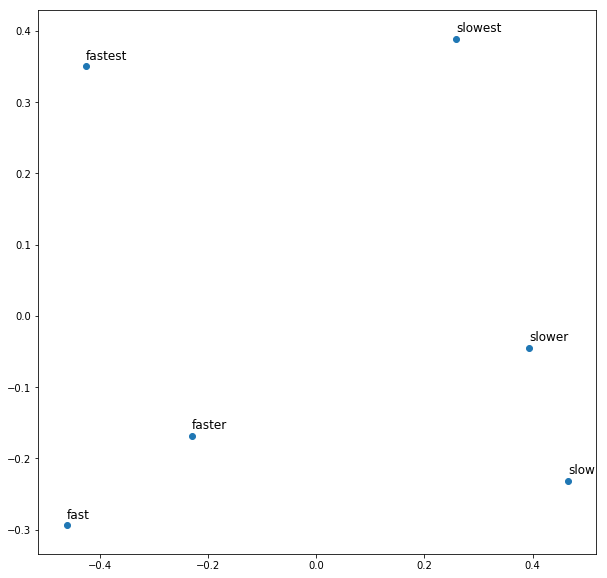

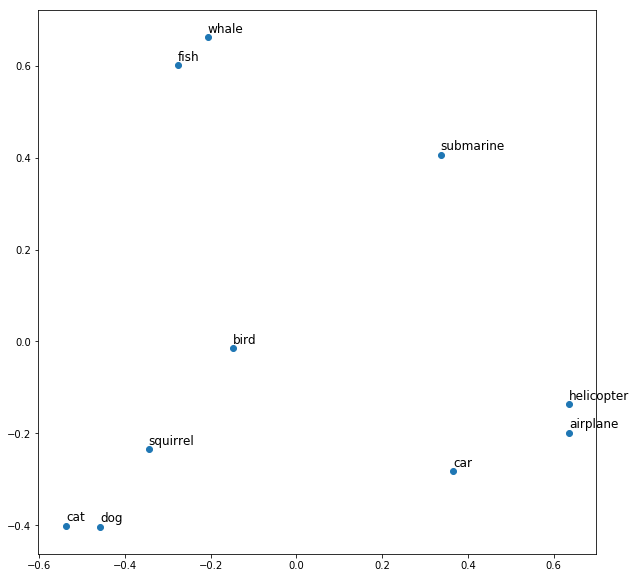

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def pcaPlot(word_list) :
    # fetch list of word vectors
    vecs = [words[x] for x in word_list]
    
    #reduce dimensions
    model = PCA(n_components = 2)
    reduced = model.fit_transform(vecs)
    xc = [v[0] for v in reduced]
    yc = [v[1] for v in reduced]
    
    # plot them
    plt.figure(figsize=(10,10))
    plt.scatter(xc, yc)

    # label the plot
    for i, word in enumerate(word_list) :
    	plt.annotate(word, xy=(xc[i], yc[i]+0.01), fontsize=12)
    plt.show()

pcaPlot(['fast','faster','fastest','slow','slower','slowest'])
pcaPlot(['bird', 'cat', 'squirrel', 'dog', 'fish', 'helicopter', 'airplane', 'car', 'submarine', 'whale'])

In [11]:
# Deleting notebook artifacts
! rm -rf numberbatch-en-17.06.txt.gz
! rm numberbatch-en-17.06.txt